# Evaluating scGPT cell embeddings

This code imports necessary libraries, filters out certain types of warnings, and imports modules and custom logging objects for use in subsequent operations.

In [18]:
import pandas as pd

import scgpt
import flash_attn
import torch

import os
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sc_foundation_evals import cell_embeddings, scgpt_forward, data, model_output
from sc_foundation_evals.helpers.custom_logging import log

log.setLevel(logging.INFO)

#### Setting up variables

This code snippet sets up parameters and file paths for both evaluating a pre-trained scGPT model and processing single-cell genomics data using scGPT. The parameters and paths configure the scGPT model and prepare the 68k PBMC scRNA-seq data for analysis and evaluation. Note that the batch column is set to "cell_names" because the dataset consists of only one batch, which only includes cells of the same type.

In [19]:
# path to the pre-trained model, 3 files are expected: 
# model_weights (best_model.pt), model args (args.json), and model vocab (vocab.json)
scGPT_dir = "/home/cog/nlandzaat/rep_learning_sc_foundation/scGPT_human-20231219T082236Z-001/scGPT_human"
# batch_size depends on available GPU memory; should be a multiple of 8
batch_size=24
# output_dir is the path to which the results should be saved
file_path_out_scGPT = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/scGPT_output_PBMC"
# path to where we will store the embeddings and other evaluation outputs
model_out = os.path.join(file_path_out_scGPT, "model_outputs")
# if you can use multithreading specify num_workers
num_workers=0

In [20]:
input_bins=51
model_run="pretrained"
seed=7
n_hvg=1200
# maximum sequence of the input is controlled by max_seq_len, this is the pretrained default
max_seq_len=1200

In [21]:
# specify the path to anndata object
dataset_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/raw/adata_GF.h5ad"
# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols"
# batch column found in adata.obs
batch_col = "cell_names" #"batch"
# where are labels stored in adata.obs? 
label_cols = "cell_names"
# where the raw counts are stored?
layer_key = "counts"
# are the values log_norm already?
log_norm = False

### Loading model and data

This code sets up and initializes a scGPT model for analyzing single-cell genomics data. First, it creates the model instance using parameters such as the path to the saved model, batch size, and file paths for saving results. Then, it generates configuration settings including the random seed, maximum sequence length, and the number of input bins. Next, the pre-trained model is loaded. The log will indicate that some weights cannot be loaded; however, this is acceptable as long as they are prefixed with "cls_". These layers are not utilized, since we are evaluating the model in a zero-shot setting.
Next, an InputData object is created to handle the single-cell genomics dataset, specifying the path to the dataset file. Finally, the vocabulary list of the scGPT model is extracted for further processing.

In [22]:
# create scGPT instance
scgpt_model = scgpt_forward.scGPT_instance(saved_model_path = scGPT_dir,
                                           model_run = model_run,
                                           batch_size = batch_size, 
                                           save_dir = file_path_out_scGPT,
                                           num_workers = num_workers, 
                                           explicit_save_dir = True)

INFO     | 2024-04-02 13:00:01 | Using device cuda


In [23]:
# create config
scgpt_model.create_configs(seed = seed, 
                           max_seq_len = max_seq_len, 
                           n_bins = input_bins)

In [24]:
# load pretrained model
scgpt_model.load_pretrained_model()

WARNING  | 2024-04-02 13:00:02 | Overriding pre-trained config['save_dir'] with /home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/scGPT_output_PBMC (was /scratch/ssd004/datasets/cellxgene/save/cellxgene_census_human-May23-08-36-2023)
WARNING  | 2024-04-02 13:00:02 | Overriding pre-trained config['max_seq_len'] with 1200 (was 1200)
INFO     | 2024-04-02 13:00:02 | Loading vocab from /home/cog/nlandzaat/rep_learning_sc_foundation/scGPT_human-20231219T082236Z-001/scGPT_human/vocab.json


INFO     | 2024-04-02 13:00:03 | Loading model from /home/cog/nlandzaat/rep_learning_sc_foundation/scGPT_human-20231219T082236Z-001/scGPT_human/best_model.pt
WARNING  | 2024-04-02 13:00:04 | Loading partial model params from /home/cog/nlandzaat/rep_learning_sc_foundation/scGPT_human-20231219T082236Z-001/scGPT_human/best_model.pt


RuntimeError: Attempting to deserialize object on CUDA device 0 but torch.cuda.device_count() is 0. Please use torch.load with map_location to map your storages to an existing device.

In [ ]:
# create input data object
input_data = data.InputData(adata_dataset_path = dataset_path)

INFO     | 2024-02-15 11:22:16 | Loading data from /home/cog/nlandzaat/rep_learning_sc_foundation/raw/adata_GF.h5ad


In [ ]:
# load vocabulary
vocab_list = scgpt_model.vocab.get_stoi().keys()

The input data undergoes preprocessing to prepare it for further analysis using the scGPT model. The purpose is to transform raw single-cell genomics data into a format suitable for input into the scGPT model. This involves tasks such as data normalization, binning, and identifying highly variable genes. Subsequently, the preprocessed data is tokenized, converting it into individual tokens or units which makes the format compatible with the scGPT model's input requirements.

In [ ]:
# preprocessing as written in the scGPT repository, filter for the 1200 highly variable genes 

input_data.preprocess_data(gene_vocab = vocab_list,
                           model_type = "scGPT",
                           gene_col = gene_col,
                           data_is_raw = not log_norm,
                           counts_layer = layer_key, 
                           n_bins = input_bins,
                           n_hvg = n_hvg)

WARNING  | 2024-02-15 11:24:58 | Gene names not found in var columns. Using index instead.
INFO     | 2024-02-15 11:24:58 | Matched 22670/23669 genes in vocabulary of size 60697.
INFO     | 2024-02-15 11:24:58 | Preprocessing data


scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


In [ ]:
# tokenize data
scgpt_model.tokenize_data(data = input_data,
                          input_layer_key = "X_binned",
                          include_zero_genes = False)

INFO     | 2024-02-15 11:27:21 | Tokenizing data


### Evaluating embeddings

This code evaluates scGPT model embeddings on single-cell genomics data. It conducts a forward pass to extract embeddings, then assesses their performance in MLM and MVC tasks. Finally, it visualizes the embeddings with a 2D UMAP plot.

In [ ]:
# forward pass on model and extract embeddings
scgpt_model.extract_embeddings(data = input_data)

INFO     | 2024-02-15 11:27:27 | Preparing dataloader
INFO     | 2024-02-15 11:27:27 | Saving config to /home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/scGPT_output
INFO     | 2024-02-15 11:27:27 | Extracting embeddings
INFO     | 2024-02-15 11:27:27 | Extracting embeddings for batch 1/2858


INFO     | 2024-02-15 11:27:46 | Extracting embeddings for batch 286/2858
INFO     | 2024-02-15 11:27:53 | Extracting embeddings for batch 571/2858
INFO     | 2024-02-15 11:27:59 | Extracting embeddings for batch 856/2858
INFO     | 2024-02-15 11:28:06 | Extracting embeddings for batch 1141/2858
INFO     | 2024-02-15 11:28:13 | Extracting embeddings for batch 1426/2858
INFO     | 2024-02-15 11:28:20 | Extracting embeddings for batch 1711/2858
INFO     | 2024-02-15 11:28:27 | Extracting embeddings for batch 1996/2858
INFO     | 2024-02-15 11:28:33 | Extracting embeddings for batch 2281/2858
INFO     | 2024-02-15 11:28:40 | Extracting embeddings for batch 2566/2858
INFO     | 2024-02-15 11:28:47 | Extracting embeddings for batch 2851/2858


In [ ]:
# save embeddings to a DataFrame
scGPT_embeddings_df = pd.DataFrame(scgpt_model.cell_embeddings)

# save the DataFrame with embeddings to a CSV file
scGPT_embedding_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/scGPT_embeddings_PBMC.csv"
scGPT_embeddings_df.to_csv(scGPT_embedding_file_path, index=False)

In [ ]:
# evaluate mlm (masked language modeling) and mvc (multi-view clustering a.k.a. gene expression prediction from cell embedding) output
eval_pred = model_output.GeneExprPredEval(scgpt_model,
                                         data = input_data,
                                         output_dir = model_out,
                                         embedding_key = ["mlm_output", 
                                                          "mvc_output"])

In [ ]:
eval_pred.evaluate()

WARNING  | 2024-02-06 14:49:53 | mlm_output is not a tensor


WARNING  | 2024-02-06 14:49:54 | mvc_output is not a tensor


,MSE,MSE_all,MRE,MRE_all,MAE,MAE_all
mlm_output,218.360870,218.360870,0.444961,0.444961,12.603579,12.603579
mvc_output,122.182549,122.182549,0.375481,0.377393,8.691319,8.691319
mean,208.858597,208.858597,0.495731,0.495731,12.562315,12.562315


In [ ]:
eval_ce = cell_embeddings.CellEmbeddingsEval(scgpt_model,
                                             data = input_data,
                                             output_dir = model_out,
                                             label_key = label_cols,
                                             batch_key = batch_col)

WARNING  | 2024-02-06 14:51:12 | adata_ has 68579 cells. Taking a subset of 7500 cells.


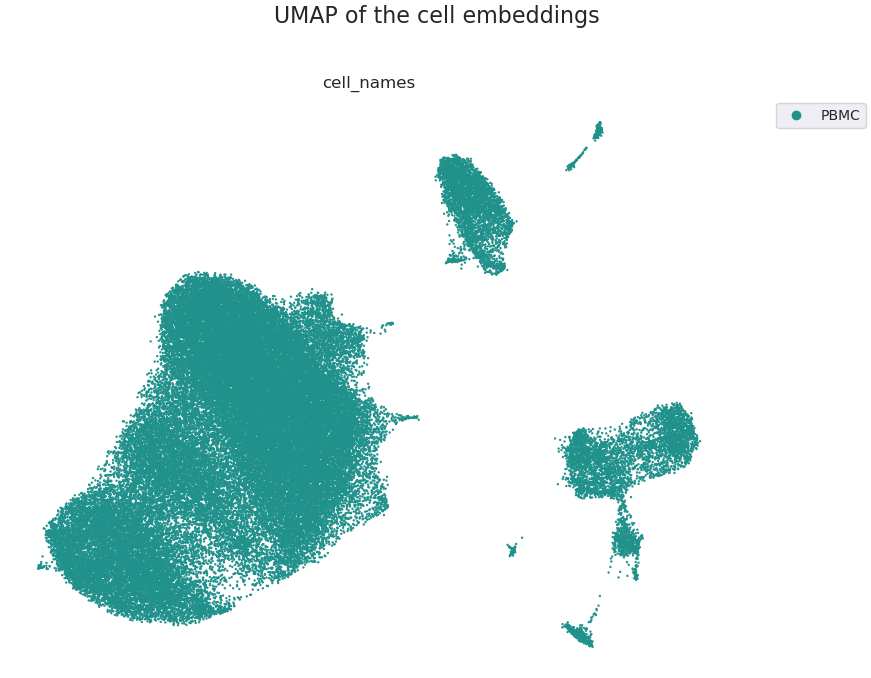

In [ ]:
# visualize embeddings
eval_ce.visualize(plot_title = "UMAP of the PBMC cell embeddings by scGPT")